https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

In [47]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
%matplotlib inline
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [48]:
class TextCNN:

    def __init__(
      self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                bn_conv = self.batch_normalization(conv) 
                h = tf.nn.relu(tf.nn.bias_add(bn_conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                dropped = tf.nn.dropout(pooled, self.dropout_keep_prob, name="dropout")
                outputs.append(dropped)


        num_filters_total = num_filters * len(filter_sizes)
        self.h = tf.concat(outputs, 3)
        self.h_flat = tf.reshape(self.h, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.01), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            self.correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_predictions, "float"), name="accuracy") 
            
            
    def batch_normalization(self, x):
        """
          x -> γ(x-μ)/√（σ^2-ε）　+ β
      
          γ : scale
          μ: mean (first moment)
          σ: variance (second moment)
          β: offset
          ε: to avoid dividing by 0
        """
        epsilon = 1e-5
        dim = x.get_shape()[-1]
        scale = tf.Variable(tf.ones([dim]))
        offset = tf.Variable(tf.zeros([dim]))
        mean, variance = tf.nn.moments(x, [0,1,2])
        return tf.nn.batch_normalization(x, mean, variance, offset, scale, epsilon)

In [49]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"

positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

long_doc =True

#positive_data_file = "data/chABSA/pos.txt"
#negative_data_file = "data/chABSA/neg.txt"

In [50]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        positive_examples = [s.strip() for s in positive_examples]
        negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y

In [51]:
%%notify
x_text, y = load_data_and_labels(positive_data_file, negative_data_file)

<IPython.core.display.Javascript object>

In [52]:
len(x_text)

26260

In [53]:
x_text[0]

' 夏 の 子 ど も 用 プ ー ル に 使 う た め 購 入 し ま し た 。 朝 、 水 を 張 っ て プ ー ル の 水 温 を 上 げ た い の で す が 、 音 は 結 構 す る の で 前 日 か ら 膨 ら ま せ て 遊 ぶ 直 前 に 追 加 で 空 気 入 れ た り し て 使 い ま く り ま し た ！ 空 気 を 入 れ る 以 外 に 抜 く こ と も 出 来 て プ ー ル を コ ン パ ク ト に 収 納 で き ま し た 。 夏 が 終 わ り 、 秋 に な り 落 ち 葉 が 気 に な り 出 し た こ ろ も し か し て ？ 砂 利 の 上 に 紛 れ た 落 ち 葉 に 向 か っ て 使 っ た ら 落 ち 葉 集 め が 楽 に な る ！ ？ と か 、 思 っ た の に 未 だ に 落 ち 葉 に は 使 わ ず で す ( ^ _ ^ ; ) \n '

In [54]:
length_list = np.array([len(r)for r in x_text])

In [55]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,421
1,149
2,221
3,253
4,473


In [56]:
df.describe(percentiles=[0.5,0.75,0.8,0.9])

,length
count,26260.000000
mean,266.630922
std,375.807554
min,13.000000
50%,183.000000
75%,305.000000
80%,345.000000
90%,489.000000
max,17495.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2e9394e0>]],
      dtype=object)

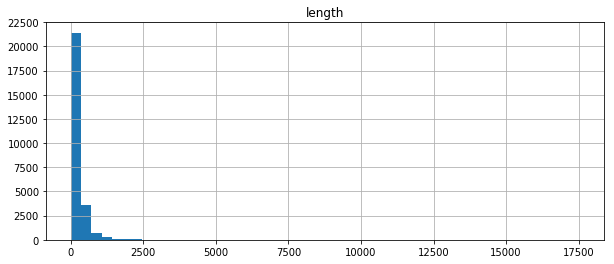

In [57]:
df.hist(bins=50,figsize=(10,4))

In [58]:
#max_length = 1000
max_length = 400
if long_doc:
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9])

,length
count,26260.000000
mean,210.584311
std,114.718538
min,13.000000
50%,183.000000
75%,305.000000
80%,345.000000
90%,400.000000
max,400.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c291b1668>]],
      dtype=object)

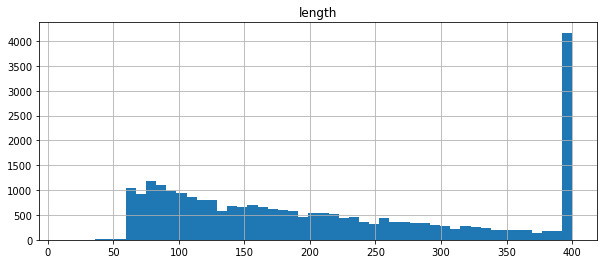

In [59]:
df.hist(bins=50,figsize=(10,4))

In [60]:
level = "char" #"word"

In [61]:
if level == "word":
    max_document_length = max([len(x.split(" ")) for x in x_text])
elif level == "char":
    max_document_length = max([len(x) for x in x_text])
print("max document length", max_document_length)

max document length 400


In [62]:
vocab_processor = preprocessing.VocabularyProcessor(max_document_length)

In [63]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

<IPython.core.display.Javascript object>

In [64]:
test_percentage = 0.05#0.0010 #0.1

In [65]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 2777
Train/Test split: 24947/1313


<IPython.core.display.Javascript object>

In [66]:
print(x_train.shape)

(24947, 400)


In [67]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [68]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [69]:
embedding_size = 64     
filter_sizes = [2,3,4,5]    
num_filters=128               
dropout_keep_prob=0.5
l2_reg_lambda=0.1      

In [70]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

In [71]:
time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs", time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/2018_07_02_19_55_09/



In [72]:
batch_size = 64                  
num_epochs = 200            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

In [73]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            predictions, step, summaries, loss, accuracy = sess.run([cnn.predictions, global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            print(len(np.where(predictions==1)[0]))
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/hist is illegal; using conv-maxpool-2/Variable_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/Variable:0/grad/sparsity is illegal; using conv-maxpool-2/Variable_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/Vari

KeyboardInterrupt: 

char level cnn 
- 1525408577  
- 1526189751 chABSA  good
- 1523936751 amazon good

In [74]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [78]:
def check_neg_posi(text):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
              allow_soft_placement=allow_soft_placement,
              log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=max_length,
                num_classes=2,
                vocab_size=vocab_size,
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, latest_ckpt)
        
            text = [s.replace(" ", "").replace("", " ").lower() for s in [text]]
            x = np.array(list(vocab_processor.fit_transform(text)))
            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            sess.run(tf.global_variables_initializer())
            feature_2 = sess.run(cnn.scores, feed_dict=feed_dict)
    print(feature_2[0])
    if np.argmax(feature_2[0]):
        print("positive")
    else:
        print("negative")

In [79]:
check_neg_posi("当四半期連結累計期間の営業利益は、前年同期比5,184億円増加し、7,127億円となりました。この大幅な増益は、主に半導体分野の大幅な損益改善及び前年同期に映画分野の営業権の減損損失を計上していたことによるものです。 ")

INFO:tensorflow:Restoring parameters from /Users/tdual/Workspace/char_level_cnn/runs/2018_07_02_19_55_09/checkpoints/model-19700
[0.093891  0.0793177]
negative


In [80]:
check_neg_posi("伸び率は減少傾向にありました。")

INFO:tensorflow:Restoring parameters from /Users/tdual/Workspace/char_level_cnn/runs/2018_07_02_19_55_09/checkpoints/model-19700
[0.14043489 0.11452279]
negative


In [81]:
check_neg_posi("伸び率は加向にありました。")

INFO:tensorflow:Restoring parameters from /Users/tdual/Workspace/char_level_cnn/runs/2018_07_02_19_55_09/checkpoints/model-19700
[0.13604924 0.02145737]
negative


In [ ]:
check_neg_posi("伸び率は減向にありました。")

In [ ]:
out_dir="runs/1523936751"

In [ ]:
ckpt_dir = os.path.join(out_dir, "checkpoints" )
latest_ckpt = tf.train.get_checkpoint_state(ckpt_dir).model_checkpoint_path

In [ ]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join(out_dir, "vocab"))
    with sess.as_default():
        cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_size,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, latest_ckpt)
        #sess.run(tf.global_variables_initializer())
        w = sess.run(cnn.W, feed_dict={cnn.input_x: x_test})

In [ ]:
w

In [ ]:
w.shape

In [ ]:
with open('embedding_tensor.tsv','w') as f:
    for char_vec in w:
        for weight in char_vec:
            f.write(str(weight)+ "\t")
        f.write("\n")

In [ ]:
#vocab_dict = vocab_processor.vocabulary_._mapping
vocab_dict = vocab_processor.vocabulary_._reverse_mapping

In [ ]:
vocab_dict[1]

In [ ]:
with  open('embedding_metadata.tsv' ,'w') as f:
    f.write('Titles\tGenres\n')
    for i,v in enumerate(w):
        f.write("%s\t%s\n" % (vocab_dict[i], vocab_dict[i]))

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, latest_ckpt)

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x_text)))